In [30]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections
import pygame

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model


# disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ###### Tensorflow-GPU ########
try:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU found")
except:
  print("No GPU found")


GPU found


## environment


In [35]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)  # Car color
GREEN = (0, 255, 0)  # Goal


class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'E'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.visited_positions = set()
        self.reset()

        # Pygame initialization
        pygame.init()
        self.window_width = 600
        self.window_height = 600
        self.screen = pygame.display.set_mode((self.window_width, self.window_height))
        self.cell_width = self.window_width / maze_size_x
        self.cell_height = self.window_height / maze_size_y
        # pygame clock
        self.clock = pygame.time.Clock()
        pygame.display.set_caption("RC Maze Game")

        # Load assets
        self.car_image = self.load_image(
            "../textures/car.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.wall_image = self.load_image(
            "../textures/wall_center.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.goal_image = self.load_image(
            "../textures/door_closed.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.floor_image = self.load_image(
            "../textures/floor_mud_e.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = self.load_image(
            "../textures/gargoyle_top_1.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = pygame.transform.rotate(self.top_of_wall, 180)

    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        ]

        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'E'
        self.update_sensor_readings()
        self.previous_steps = self.steps
        self.steps = 0
        self.previous_distance = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):

        if action == 0:
            self.move_forward()
        elif action == 1:  # Turn left
            self.turn_left()
        elif action == 2:  # Turn right
            self.turn_right()

        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()

        return self.get_state(), reward, done

    def move_forward(self):
        x, y = self.car_position

        # Check sensor reading in the direction of car's orientation
        if self.sensor_readings['front'] <= 4:
            # If the sensor reading is 4 or less, do not move forward
            return

        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000

    def compute_reward(self):
        """
        Compute the reward based on the current state of the environment


        @return The reward to be added to the step function
        """
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        # If the sensor is on the front left right or front side of the sensor is not on the board.
        if any(
            self.sensor_readings[direction] == 0
            for direction in ["front", "left", "right"]
        ):
            reward -= 20

        # Check if goal is reached
        # The reward of the goal.
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            # If the reward is more than 1000 steps then the reward is decremented by 200.
            if self.steps > 1000:
                reward -= 200
            

        # Calculate the Euclidean distance to the goal
        distance_to_goal = (
            (self.car_position[0] - self.goal[0]) ** 2
            + (self.car_position[1] - self.goal[1]) ** 2
        ) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (
            distance_to_goal + 1
        )  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        # Move the reward to the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        # Apply a penalty to revisit the same position
        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10

        # Penalize for each step taken to encourage efficiency
        reward -= 5

        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        # is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11

    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]

        state = car_position + [self.car_orientation] + sensor_readings

        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)

        # get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3

        state = np.array(state, dtype=float)

        return state

    def load_image(self, image_path, width, height):
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (width, height))
        return image

    def draw_maze(self):
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                if self.maze[y][x] == 1:
                    self.screen.blit(
                        self.wall_image, (x * self.cell_width, y * self.cell_height)
                    )

                    self.screen.blit(
                        self.top_of_wall, (x * self.cell_width, y * self.cell_height)
                    )
                    # add top of wall
                if self.maze[y][x] == 0:
                    self.screen.blit(
                        self.floor_image, (x * self.cell_width, y * self.cell_height)
                    )

    def draw_car(self):
        if self.car_orientation == "N":
            car_image = pygame.transform.rotate(self.car_image, 180)
        elif self.car_orientation == "E":
            car_image = pygame.transform.rotate(self.car_image, 90)
        elif self.car_orientation == "S":
            car_image = self.car_image
        elif self.car_orientation == "W":
            car_image = pygame.transform.rotate(self.car_image, 270)

        self.screen.blit(
            car_image,
            (
                self.car_position[0] * self.cell_width,
                self.car_position[1] * self.cell_height,
            ),
        )

    def draw_goal(self):
        self.screen.blit(
            self.goal_image,
            (self.goal[0] * self.cell_width, self.goal[1] * self.cell_height),
        )

    def render(self,render_mode='human', framerate=60, delay=0):
        if render_mode == 'human':
            self.draw_maze()
            self.draw_car()
            self.draw_goal()
            pygame.display.flip()
            self.clock.tick(framerate)  
        elif render_mode == 'rgb_array':
            rendered_maze = np.array(self.maze, dtype=str)
            x, y = self.car_position
            rendered_maze[y][x] = 'C'
            # print array
            print(rendered_maze, '\n')

    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

# TODO: ADD TRAINING TIME COMPARISON, OR TIME PER EPISODE

# DDQN

In [36]:
mse = tf.keras.losses.MeanSquaredError()
class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)

    def buildNetwork(self):
        """
        Builds and compiles the neural network. This is a helper to allow subclasses to override the build method in order to add more features such as learning rate and loss.


        @return A Sequential object that can be used to train the
        """
        model = Sequential(
            [
                Input(shape=self.input_shape),
                Dense(32, activation="relu"),
                Dense(64, activation="relu"),
                Dense(32, activation="relu"),
                Dense(self.output_shape, activation="linear"),
            ]
        )
        model.compile(
            loss=mse,
            optimizer=Adam(learning_rate=self.learning_rate),
            metrics=["mean_squared_error"],  # Use the string identifier
        )
        return model

    def policy_network_fit(self, batch, batch_size):
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Predict Q-values for starting state using the policy network
        q_values = self.policy_model.predict(states)

        # Predict Q-values for next state using the policy network
        q_values_next_state_policy = self.policy_model.predict(next_states)

        # Select the best action for the next state using the policy network
        best_actions = np.argmax(q_values_next_state_policy, axis=1)

        # Predict Q-values for next state using the target network
        q_values_next_state_target = self.target_model.predict(next_states)

        # Update Q-values for actions taken
        for i in range(batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                # Double DQN update rule
                q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

        # Train the policy network
        History = self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)
        return History

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

## training

In [37]:
env = RCMazeEnv()
state = env.reset()


# Model parameters
REPLAY_MEMORY_CAPACITY = 2000000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)

# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99993
EPISODE_AMOUNT = 170

# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []
loss_history = []
epsilon_history = []
mse_history = []

# step history for each episode
episode_path_history = []
step_history = []
action_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode

    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)

    while not done:
        env.render(delay=0, framerate=720)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])
            
        # add the action to the action history
        action_history.append((episode, action))

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        # add the current car position to the episode path history with the episode number
        episode_path_history.append((episode, env.car_position))
        
        
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory

            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)

            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]

            # fit model
            history = agent.policy_network_fit(miniBatch, BATCH_SIZE)

            loss_history.append(history.history['loss'])
            mse_history.append(history.history["mean_squared_error"])

        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON, 'and steps = ', step_counter)
    step_history.append(step_counter)
    reward_history.append(episode_reward)


env.close_pygame()
env.close()

2024-04-09 19:12:17.585240: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_70/kernel/Assign' id:5032 op device:{requested: '', assigned: ''} def:{{{node dense_70/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_70/kernel, dense_70/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-09 19:12:18.211442: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_67/BiasAdd' id:4927 op device:{requested: '', assigned: ''} def:{{{node dense_67/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_67/MatMul, dense_67/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in th

episodeReward for episode  0 =  -4109.145618509661 with epsilon =  0.9482834318441206 and steps =  742
episodeReward for episode  1 =  -8210.637001137819 with epsilon =  0.8712687404363714 and steps =  1210
episodeReward for episode  2 =  -780.8934127732159 with epsilon =  0.8510744847438162 and steps =  335
episodeReward for episode  3 =  -9297.934430057903 with epsilon =  0.772541912044149 and steps =  1383
episodeReward for episode  4 =  -1630.9053284009274 with epsilon =  0.7474333264630229 and steps =  472
episodeReward for episode  5 =  621.5149896031618 with epsilon =  0.7380227586829833 and steps =  181
episodeReward for episode  6 =  -6117.009988418119 with epsilon =  0.6680487673828679 and steps =  1423
episodeReward for episode  7 =  19.92665699119607 with epsilon =  0.6522450520373092 and steps =  342
episodeReward for episode  8 =  -137.90842396139158 with epsilon =  0.639898563407132 and steps =  273
episodeReward for episode  9 =  584.1130149192853 with epsilon =  0.6339

In [38]:
env.close_pygame()

## results

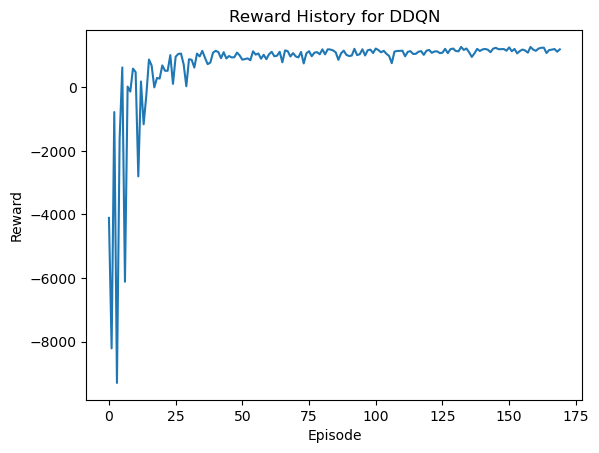

In [65]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for DDQN")
plt.savefig('../images/training_images/reward_history_DDQN.png')
plt.show()
# save the image

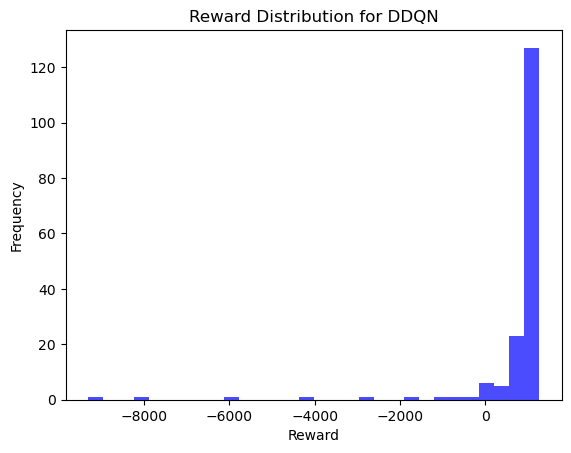

In [66]:
def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.savefig("../images/training_images/reward_distribution_DDQN.png")
    plt.show()
    # save the image


# Example usage:
# Assuming `rewards` is a list of total rewards per episode.
# plot_reward_distribution(rewards)
plot_reward_distribution(reward_history, title="Reward Distribution for DDQN")

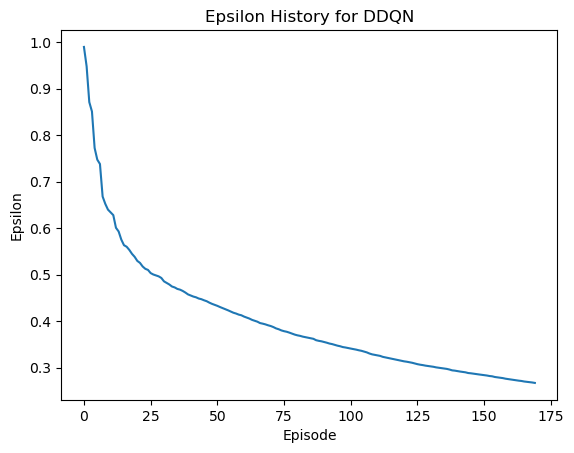

In [67]:
# plot epsilon over time
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon History for DDQN")
plt.savefig("../images/training_images/epsilon_history_DDQN.png")
plt.show()
# save the image

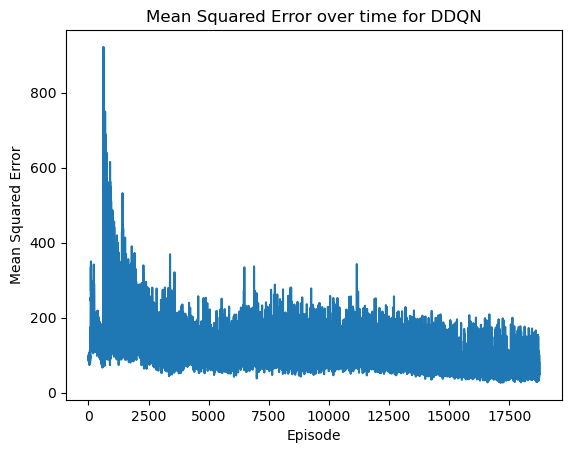

In [68]:
# evalution

# plot mse
plt.plot(mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time for DDQN")
plt.savefig("../images/training_images/mse_history_DDQN.png")
plt.show()
# save the image

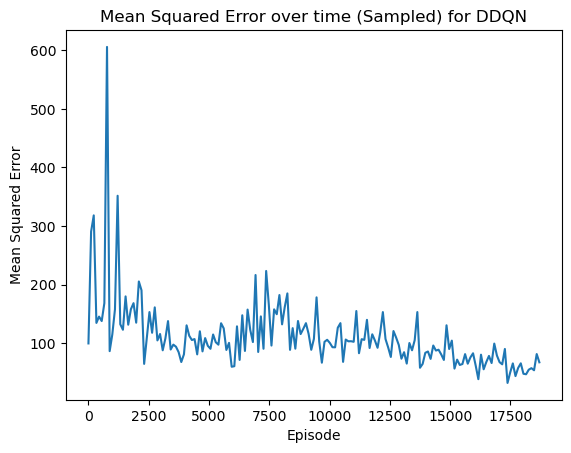

In [69]:
# Assuming mse_history is a flat list with the correct number of elements
EPISODE_AMOUNT = len(mse_history)  # Make sure this reflects the actual number of episodes
desired_samples = 170  # The number of points you want to plot

# Calculate the step size
step = max(EPISODE_AMOUNT // desired_samples, 1)  # Avoid division by zero
sampled_mse_history = mse_history[::step]

# Ensure sampled_episodes has the same number of elements as sampled_mse_history
sampled_episodes = list(range(0, EPISODE_AMOUNT, step))[:len(sampled_mse_history)]

plt.plot(sampled_episodes, sampled_mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time (Sampled) for DDQN")
plt.savefig("../images/training_images/mse_history_sampled_DDQN.png")
plt.show()
# save the image

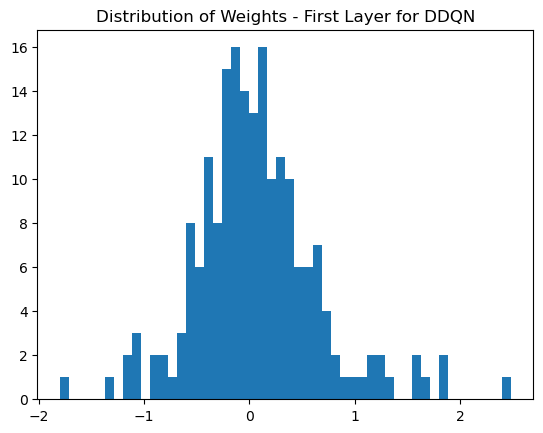

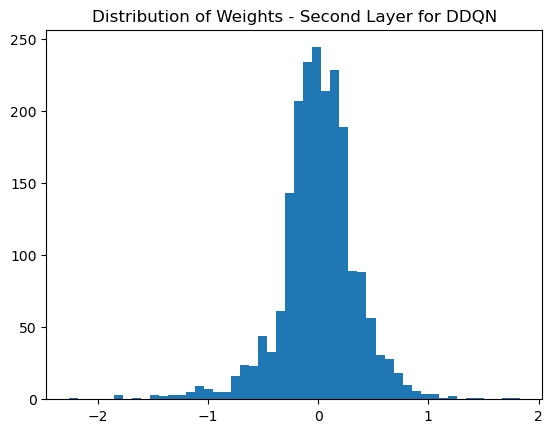

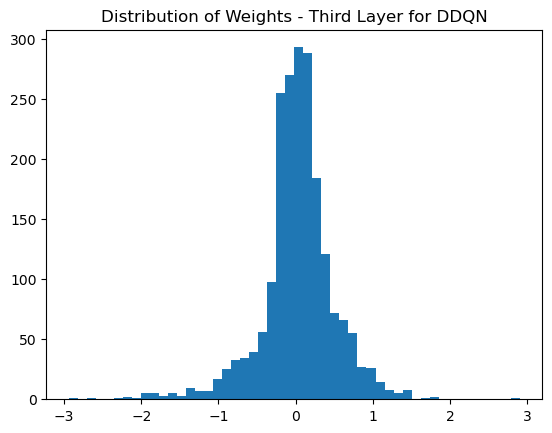

In [70]:
weights, biases = agent.policy_model.layers[0].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - First Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_first_layer_DDQN.png")
plt.show()
# save the image

# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[1].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Second Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_second_layer_DDQN.png")
plt.show()
# save the image


# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[2].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Third Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_third_layer_DDQN.png")
plt.show()
# save the image

In [46]:
# save model
agent.policy_model.save('../models/DDQN_RCmaze_v3.h5')

/home/lucas/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


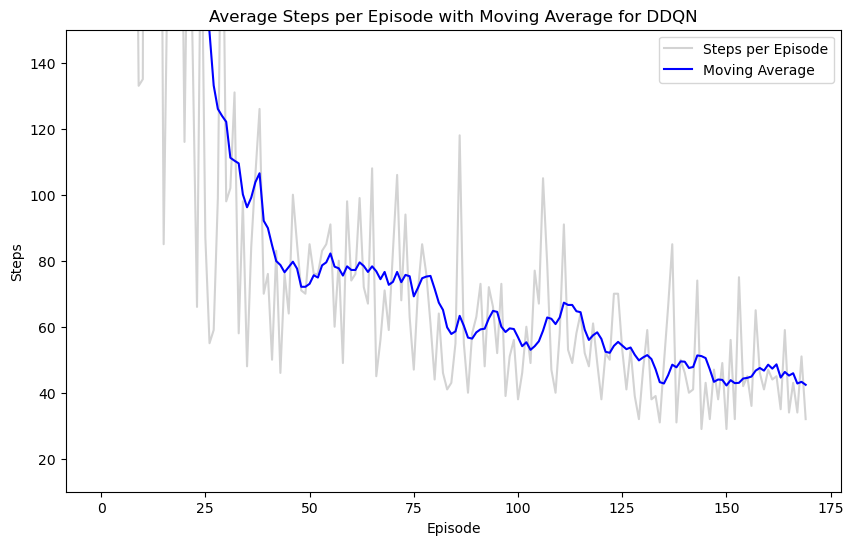

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate moving average
window_size = 10
moving_avg = np.convolve(step_history, np.ones(window_size) / window_size, mode="valid")

low_point = np.argmin(moving_avg)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_history, label="Steps per Episode", color="lightgray")
plt.plot(
    range(window_size - 1, len(step_history)),
    moving_avg,
    label="Moving Average",
    color="blue",
)
# Highlight the lowest point
plt.scatter(low_point, moving_avg[low_point], color="red", label="Lowest Point")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.ylim(10, 150)
plt.title("Average Steps per Episode with Moving Average for DDQN")
plt.legend()
plt.savefig("../images/training_images/steps_per_episode_with_moving_avg_DDQN.png")
plt.show()

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1 -1 -1 -1 -1 -1  0 -1]
 [-1  0 -1  0 -1 -1  0  0  0  0  0 -1]
 [-1  0  0  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  0 -1  0  0  0  0 -1  0 -1 -1 -1]
 [-1  0 -1 -1  0 -1  0  0  0  0  0 -1]
 [-1  0 -1  0  0 -1 -1 -1 -1 -1  0 -1]
 [-1  0  0  0 -1 -1  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


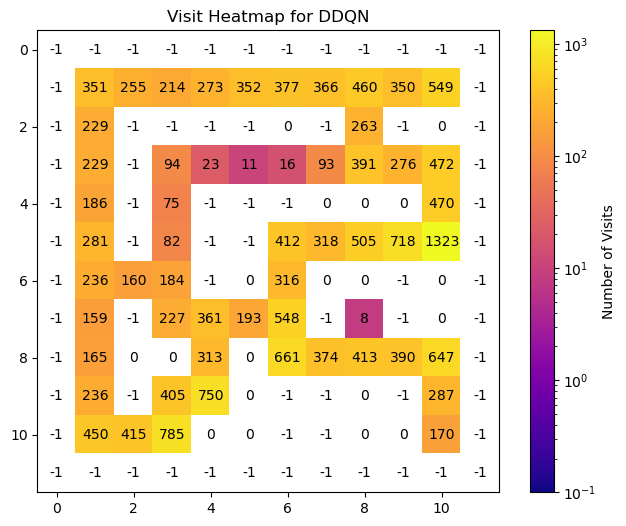

In [71]:
# Assuming maze_size_x and maze_size_y are the dimensions of your maze
# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)

visit_counts[env.maze == 1] = -1
print(visit_counts)


for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm


def plot_visit_heatmap(visit_counts, title="Visit Heatmap"):
    # Transpose visit_counts to match the expected orientation
    visit_counts_transposed = visit_counts.T  # Transpose the matrix

    # Filter out the wall cells by setting their count to NaN for visualization
    filtered_counts = np.where(
        visit_counts_transposed == -1, np.nan, visit_counts_transposed
    )

    # Define a continuous colormap (you can choose any colormap you like)
    cmap = plt.cm.plasma
    cmap.set_bad("white")  # Use gray for NaN (walls)
    plt.figure(figsize=(8, 6))
    # Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
    plt.imshow(
        filtered_counts,
        cmap=cmap,
        norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
        interpolation="nearest",
    )
    # add the nr of visits to the cells
    for i in range(visit_counts_transposed.shape[0]):
        for j in range(visit_counts_transposed.shape[1]):
            if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
                plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

    plt.colorbar(label="Number of Visits")
    plt.title(title)
    plt.savefig("../images/training_images/visit_heatmap_DDQN.png")
    plt.show()
    # save the image


plot_visit_heatmap(visit_counts, title="Visit Heatmap for DDQN")

[742, 1210, 335, 1383, 472, 181, 1423, 342, 273, 133, 135, 633, 190, 427, 302, 85, 175, 220, 170, 235, 116, 211, 140, 66, 192, 87, 55, 59, 99, 214, 98, 102, 131, 58, 98, 48, 84, 106, 126, 70, 76, 50, 83, 46, 76, 64, 100, 85, 71, 70, 85, 76, 76, 83, 85, 91, 60, 80, 49, 98, 74, 76, 99, 72, 67, 108, 45, 56, 71, 59, 83, 106, 68, 94, 63, 47, 71, 85, 76, 61, 44, 64, 46, 41, 43, 55, 118, 55, 40, 58, 63, 73, 48, 72, 66, 52, 73, 39, 51, 56, 38, 46, 60, 49, 77, 67, 105, 79, 47, 40, 58, 91, 53, 49, 58, 64, 52, 48, 61, 49, 38, 52, 50, 70, 70, 53, 41, 53, 39, 32, 47, 59, 38, 39, 31, 49, 66, 85, 31, 50, 46, 40, 41, 74, 29, 43, 32, 47, 38, 49, 29, 56, 32, 75, 42, 45, 36, 65, 46, 41, 47, 44, 45, 35, 59, 34, 43, 34, 51, 32]


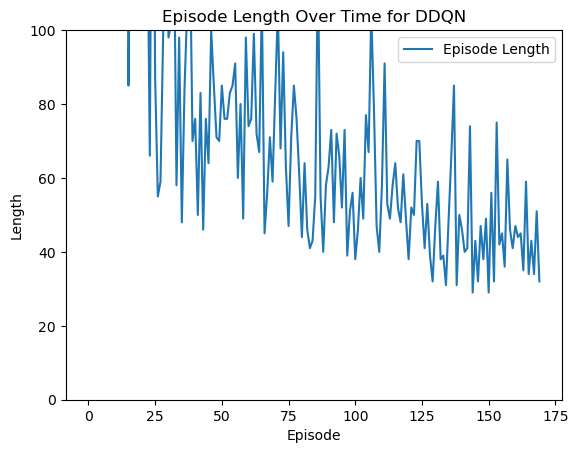

In [72]:
def plot_episode_lengths(episode_lengths, title="Episode Length Over Time"):
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title(title)
    plt.legend()
    # y limit to avoid showing outliers
    plt.ylim(0, 100)
    plt.savefig("../images/training_images/episode_length_DDQN.png")
    plt.show()
    # save the image

print(step_history)

plot_episode_lengths(step_history, title="Episode Length Over Time for DDQN")

## test

In [49]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

REPLAY_MEMORY_CAPACITY = 2000000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('../models/DDQN_RCmaze_v3.h5')


done = False

rewards = []
solution_path = []
test_steps = 0

while not done:
    env.render(delay=100, framerate=10)
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    test_steps += 1
    print(env.car_position)
    solution_path.append(env.car_position)
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
print('steps: ', test_steps)
env.close_pygame()

2024-04-09 19:17:38.473177: W tensorflow/c/c_api.cc:305] Operation '{name:'total_19/Assign' id:5524 op device:{requested: '', assigned: ''} def:{{{node total_19/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_19, total_19/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-09 19:17:38.670049: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_64_1/kernel/Assign' id:5760 op device:{requested: '', assigned: ''} def:{{{node dense_64_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_64_1/kernel, dense_64_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 6)
(2, 6)
(3, 6)
(3, 6)
(3, 7)
(3, 7)
(4, 7)
(5, 7)
(6, 7)
(6, 7)
(6, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
(10, 8)
(10, 9)
(10, 10)
done in  25 steps
1253.5006973297018
steps:  25


In [50]:
test_agent.policy_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 32)                224       
                                                                 
 dense_65 (Dense)            (None, 64)                2112      
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 3)                 99        
                                                                 
Total params: 4515 (17.64 KB)
Trainable params: 4515 (17.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# test_agent.policy_model.save('./main_web_app/models/DDQN_RCmaze_v2.h5')# 

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 6), (2, 6), (3, 6), (3, 6), (3, 7), (3, 7), (4, 7), (5, 7), (6, 7), (6, 7), (6, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (10, 8), (10, 9), (10, 10)]


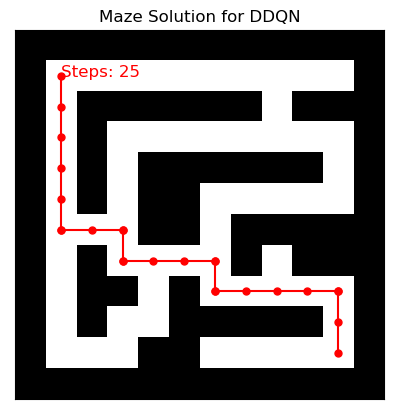

In [73]:
def plot_maze_solution(maze, path, title="Maze Solution"):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)  # Assuming path is a list of (x, y) tuples
    plt.plot(
        x, y, marker="o", color="r", markersize=5
    ) 
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title(title)
    # show nr of steps
    plt.text(1, 1, f"Steps: {len(path)}", color="red", fontsize=12)
    plt.savefig("../images/training_images/maze_solution_DDQN.png")
    plt.show()
    # save the image


# Example usage
# get the path
path = solution_path
print(path)
plot_maze_solution(env.maze, path, title="Maze Solution for DDQN")

# PPO

# q-agent

In [ ]:
class QAgent:
    def __init__(
        self,
        alpha=0.1,
        gamma=0.9,
        epsilon=0.1,
        possible_actions=3,
        min_epsilon=0.01,
        epsilon_decay=0.99,
    ):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.possible_actions = possible_actions
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay

    def state_to_tuple(self, state):

        # ((0, 0), 'N', {'front': 1, 'left': 0, 'right': 0})
        # if like this convert to ((0, 0), 'N', (1, 0, 0))
        if not isinstance(state[2], dict):
            # print(state)
            # print(state[2])
            # take state[2] and make it from this (1, 0, 0) to this {'front': 1, 'left': 0, 'right': 0}
            newState = {"front": state[2][0], "left": state[2][1], "right": state[2][2]}
            state = (state[0], state[1], newState)

        position, orientation, sensor_readings = state
        sensor_readings_tuple = tuple(sensor_readings.values())
        return (position, orientation, sensor_readings_tuple)

    def get_q_value(self, state, action):
        state_tuple = self.state_to_tuple(state)
        return self.q_table.get((state_tuple, action), 0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.possible_actions))
        else:
            state_tuple = self.state_to_tuple(state)
            q_values = [
                self.get_q_value(state_tuple, action)
                for action in range(self.possible_actions)
            ]
            max_q = max(q_values)
            actions_with_max_q = [
                action for action, q in enumerate(q_values) if q == max_q
            ]
            return random.choice(actions_with_max_q)

    def update_q_value(self, state, action, reward, next_state):
        state_tuple = self.state_to_tuple(state)
        next_state_tuple = self.state_to_tuple(next_state)
        max_q_next = max(
            [
                self.get_q_value(next_state_tuple, next_action)
                for next_action in range(self.possible_actions)
            ]
        )
        current_q = self.get_q_value(state_tuple, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
        self.q_table[(state_tuple, action)] = new_q

    def train(self, environment, num_episodes):
        reward_history = []
        for _ in range(num_episodes):
            state = environment.reset()
            done = False
            total_reward = 0
            while not done:

                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state

            # Add the total reward for this episode to the history
            reward_history.append(total_reward)

            # Decay epsilon, but not below the minimum value
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Print episode summary
            print("Episode finished after {} timesteps".format(environment.steps))
            print(
                "Total reward: {}, Epsilon: {:.3f}".format(total_reward, self.epsilon)
            )

        return reward_history

    def test(self, env):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            env.render()
            action = self.choose_action(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Test Total Reward: {total_reward}")


# Example usage:
# env = RCMazeEnv()
# agent = QAgent()
# agent.train(env, 1000)

In [ ]:
EPSILON = 0.9
ALPHA = 0.1
GAMMA = 0.6
DECAY = 0.999
MINEPSILON = 0.1
DECAY_RATE = 0.993


env = RCMazeEnv()
agent = QAgent(
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    min_epsilon=MINEPSILON,
    epsilon_decay=DECAY_RATE,
)
env.init_pygame()
agent.train(env, 1000)
env.close_pygame()

In [ ]:
# test
env = RCMazeEnv()

env.init_pygame()

# Example of running the environment
agent.test(env)


env.close_pygame()

# dqn

# a2c